# Multi-armed Bandit problem

Author: Dev Khullar

Consider a bandit problem with actions, $a = 1, \dots, 10$. The action values for these actions are selected according to a normal distribution with mean, $\mu=0$ and variance, $\sigma^2=1$. Then, for each action selected by the bandit algorithm at each time step $t$, the actual reward, $R_t$ was selected with a normal distribution with mean, $\mu = q_*(A_t)$ and variance $\sigma^2 = 1$. 

### Recall: Simple bandit problem 

Intialise, for a = 1 to k: <br>
    Q(a) $\leftarrow$ 0 <br>
    N(a) $\leftarrow$ 0 <br>

Loop forever:
     $$A = \begin{align*} \begin{cases} \text{argmax}_a Q(a) & \text{with probability } 1 - \epsilon  \\
     \text{a random action} & \text{with probability } \epsilon\end{cases}\end{align*}$$
    R $\leftarrow$ bandit(A) <br>
    N(A) $\leftarrow$ N(A) + 1 <br>
    Q(A) $\leftarrow$ Q(A) + $\frac{1}{N(A)}\left[R - Q(A) \right]$ <br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = [20, 5]
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['g', 'b', 'r', "y"])

In [2]:
# https://www.spktsagar.com/posts/2023/06/rl-multiarmed-bandit/

class StationaryMultiArmedBandit:
    """
    Represents a stationary multi-armed bandit problem.

    Attributes:
        k (int): Number of arms.
        runs (int): Number of independent runs.
        random_state (int, optional): Random seed for reproducibility.
    """
    def __init__(
            self,
            k,
            runs,
            random_state=None,
    ):
        self.k = k
        self.runs = runs
        self.random_state = random_state

        self.setup()

    def setup(self):
        """Set up the seed for reproducibility and reward distribution"""
        self.nprandom = np.random.RandomState(self.random_state)
        self.q_star = self.nprandom.normal(
            loc=0.0,
            scale=1.0,
            size=(self.runs, self.k),
        )

    def get_reward(self, action):
        """Given the action, return the reward"""
        reward = self.nprandom.normal(
            loc=self.q_star[np.arange(self.runs), action],
            scale=1.0,
        )
        return reward

    def get_correct_action(self):
        """
        Get the correct action for each run.
        Correct action for each run is the one with highest mean reward
        """
        return self.q_star.argmax(axis=1)

    def plot_reward_distribution(self, run=0):
        """Plot the reward distribution for the given run."""
        samples = self.nprandom.normal(
            loc=self.q_star[run],
            scale=1.0,
            size=(10_000, self.k),
        )
        plt.violinplot(samples, showmeans=True)
        plt.xlabel('Action')
        plt.ylabel('Reward Distribution')
        plt.show()

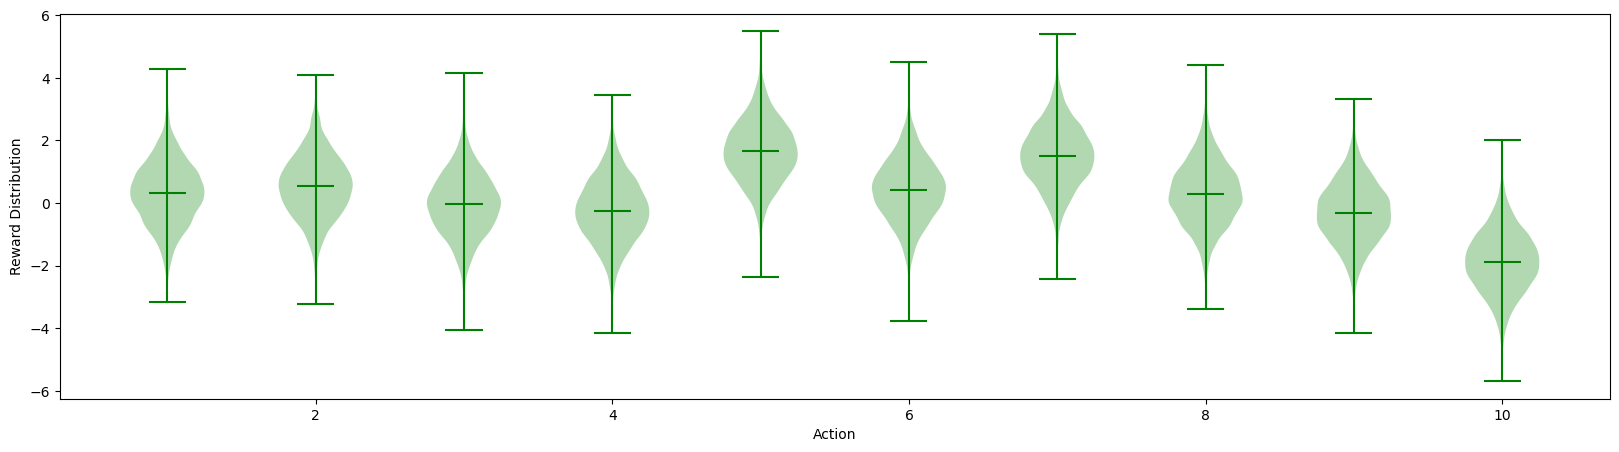

Correct action for run 0: 5


In [3]:
runs = 2000
k = 10

st_bandit = StationaryMultiArmedBandit(k=k, runs=runs)
st_bandit.plot_reward_distribution(run=0)
print(f"Correct action for run 0: {st_bandit.get_correct_action()[0] + 1}")

In [4]:
class Agent:
    """
    An epsilon-greedy agent using sample-average method for action value estimation.

    Attributes
    ----------
    k : int
        Number of actions.
    runs : int
        Number of independent runs.
    epsilon : float, optional
        Probability of choosing a random action (exploration), default is 0.1.
    random_state : int, optional
        The random number generator seed to be used, default is None.
    """
    def __init__(
            self,
            k,
            runs,
            epsilon=0.1,
            random_state=None,
    ):
        self.k = k
        self.runs = runs
        self.epsilon = epsilon
        self.random_state = random_state

        self.setup()

    def setup(self):
        """Initialize the Q and N arrays for action value estimation and action counts."""
        self.nprandom = np.random.RandomState(self.random_state)
        self.Q = np.zeros((self.runs, self.k))
        self.N = np.zeros((self.runs, self.k))

    def get_action(self):
        """Choose an action based on epsilon-greedy policy."""
        greedy_action = np.argmax(
            self.nprandom.random(self.Q.shape) * (self.Q==self.Q.max(axis=1, keepdims=True)), # breaking ties randomly
            axis=1
        )
        random_action = self.nprandom.randint(0, self.k, size=(self.runs, ))

        action = np.where(
            self.nprandom.random((self.runs, )) < self.epsilon,
            random_action,
            greedy_action,
        )
        return action

    def get_step_size(self, action):
        """Calculate the step size for updating action value estimates.
        For sample average method we return 1/number of times the action is choosen until current step"""
        return 1/self.N[np.arange(self.runs), action]

    def update(self, action, reward):
        """Update the action value estimates based on the chosen action and received reward."""
        self.N[np.arange(self.runs), action] += 1
        step_size = self.get_step_size(action)
        self.Q[np.arange(self.runs), action] += (reward - self.Q[np.arange(self.runs), action])*step_size

In [ ]:
class Bandit:
    """A test bed for running experiments with multi-armed bandits and agents.

    Attributes:
        bandit (object): A multi-armed bandit object.
        agent (object): An agent object.
        steps (int): The number of steps for the experiment.
    """
    def __init__(
            self,
            bandit,
            agent,
            steps,
    ):
        self.bandit = bandit
        self.agent = agent
        self.steps = steps

    def run_experiment(self):
        """Runs the experiment for the given number of steps and returns the average rewards and optimal actions.

        Returns:
            tuple: A tuple containing two lists: average rewards and average optimal actions for each step.
        """
        avg_reward = []
        avg_optimal_action = []

        for _ in range(self.steps):
            action = self.agent.get_action()
            reward = self.bandit.get_reward(action)
            self.agent.update(action, reward)

            correct = action == self.bandit.get_correct_action()

            avg_reward.append(reward.mean())
            ############### HOW IS THIS CALCULATING THE AVERAGE OPTIMAL ACTION? WHERE IS THE AVERAGE COMING FROM SINCE THIS IS THE MEAN ################
            avg_optimal_action.append(correct.mean())

        return avg_reward, avg_optimal_action

    @classmethod
    def run_and_plot_experiments(cls, steps, exp_bandit_agent_dict):
        """Runs multiple experiments and plots the results.

        Args:
            steps (int): The number of steps for the experiments.
            exp_bandit_agent_dict (dict): A dictionary with labels as keys and (bandit, agent) tuples as values.
        """
        fig, (ax_reward, ax_optimal_action) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

        for label, (bandit, agent) in exp_bandit_agent_dict.items():
            test_bed = cls(bandit, agent, steps)
            avg_reward, avg_optimal_action = test_bed.run_experiment()
            ax_reward.plot(avg_reward, label=label)
            ax_optimal_action.plot(avg_optimal_action, label=label)

        ax_reward.set_ylabel("Average reward")
        ax_reward.set_xlabel("Steps")

        ax_optimal_action.set_ylabel("% Optimal Action")
        ax_optimal_action.set_xlabel("Steps")

        ax_reward.legend()
        ax_optimal_action.legend()

        plt.show()


### Original Implementation from Barto and Sutton

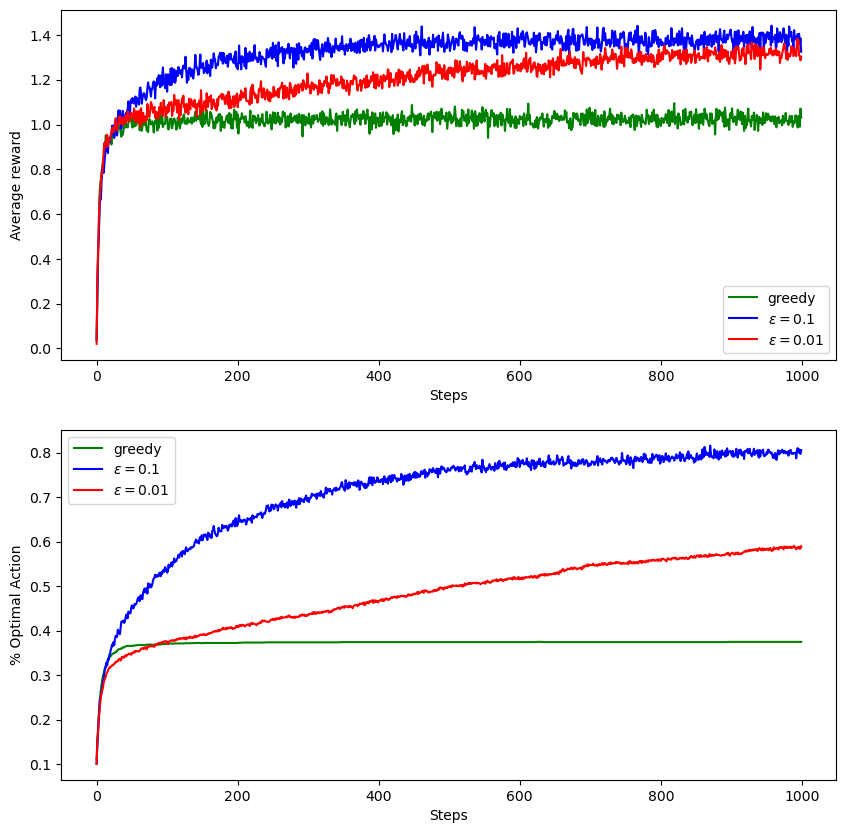

In [6]:
Bandit.run_and_plot_experiments(
    steps=1000,
    exp_bandit_agent_dict={
        "greedy": (
            StationaryMultiArmedBandit(k=k, runs=runs),
            Agent(k=k, runs=runs, epsilon=0)
        ),
        r"$\epsilon=0.1$": (
            StationaryMultiArmedBandit(k=k, runs=runs),
            Agent(k=k, runs=runs, epsilon=0.1)
        ),
        r"$\epsilon=0.01$": (
            StationaryMultiArmedBandit(k=k, runs=runs),
            Agent(k=k, runs=runs, epsilon=0.01)
        ),
    },
)

### Change step size to 100,000

FALSE INTERPRETATION

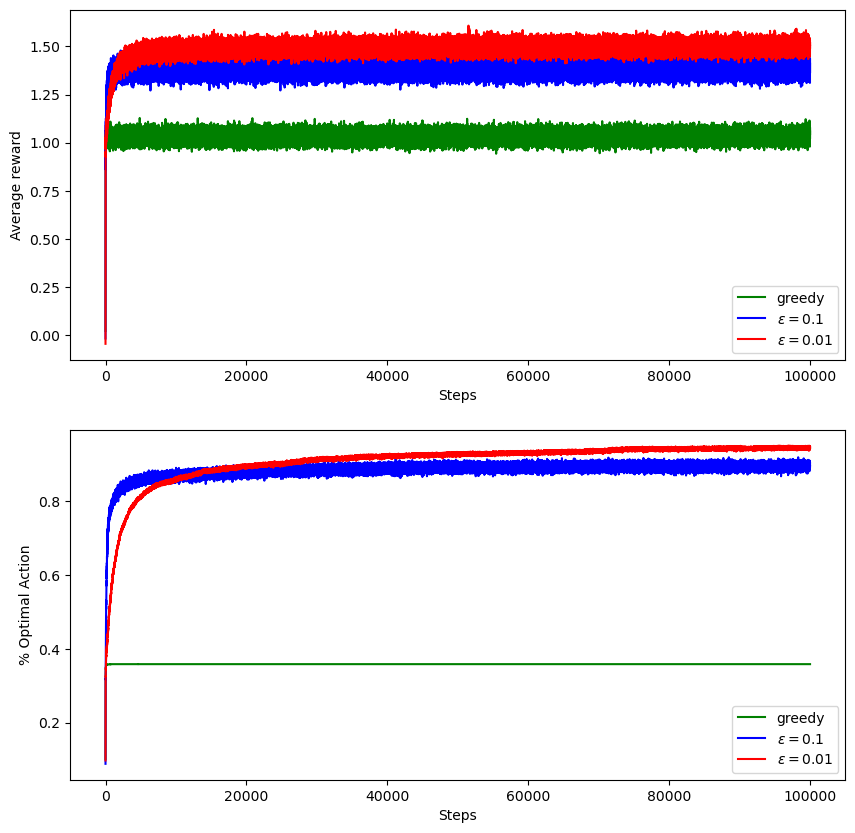

In [7]:
Bandit.run_and_plot_experiments(
    steps=100000,
    exp_bandit_agent_dict={
        "greedy": (
            StationaryMultiArmedBandit(k=k, runs=runs),
            Agent(k=k, runs=runs, epsilon=0)
        ),
        r"$\epsilon=0.1$": (
            StationaryMultiArmedBandit(k=k, runs=runs),
            Agent(k=k, runs=runs, epsilon=0.1)
        ),
        r"$\epsilon=0.01$": (
            StationaryMultiArmedBandit(k=k, runs=runs),
            Agent(k=k, runs=runs, epsilon=0.01)
        ),
    },
)

### Change k = 200, steps = 1000, epsilon=0, 0.01, 0.5

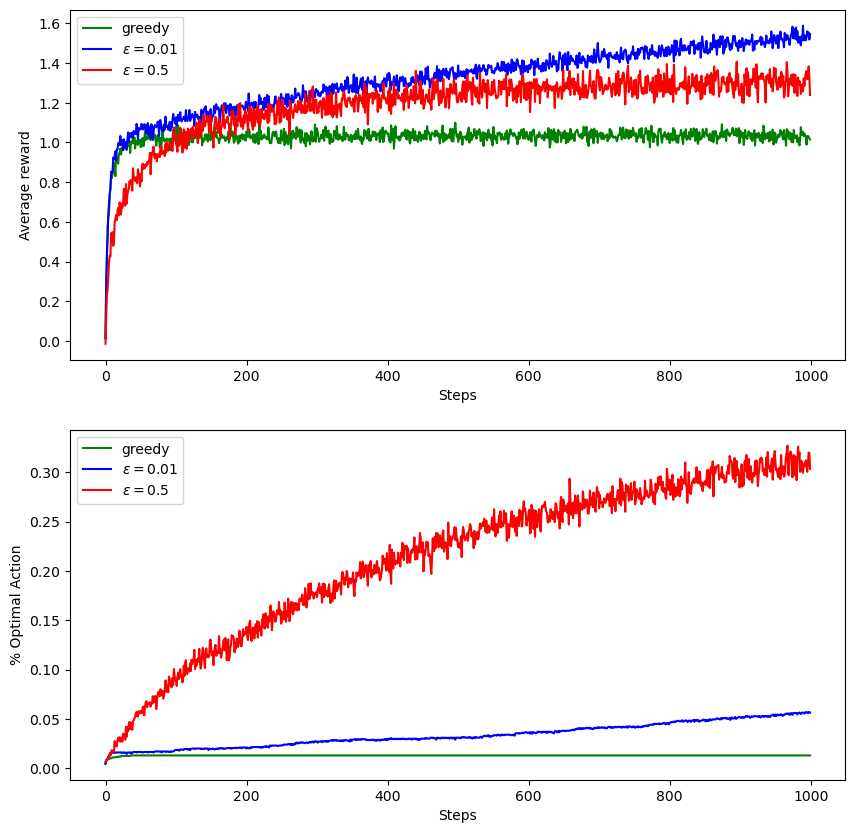

In [8]:
runs = 2000
k = 200
Bandit.run_and_plot_experiments(
    steps=1000,
    exp_bandit_agent_dict={
        "greedy": (
            StationaryMultiArmedBandit(k=k, runs=runs),
            Agent(k=k, runs=runs, epsilon=0)
        ),
        r"$\epsilon=0.01$": (
            StationaryMultiArmedBandit(k=k, runs=runs),
            Agent(k=k, runs=runs, epsilon=0.01)
        ),
        r"$\epsilon=0.5$": (
            StationaryMultiArmedBandit(k=k, runs=runs),
            Agent(k=k, runs=runs, epsilon=0.5)
        ),
    },
)

### Change k = 2, $\epsilon=0, 0.01, 0.05$

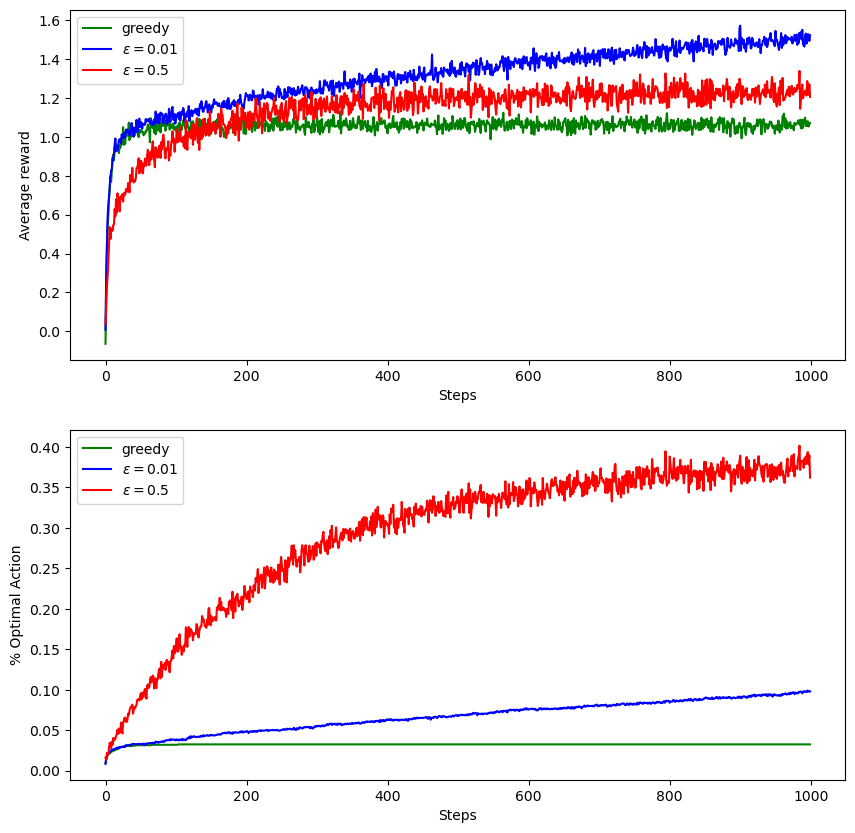

In [9]:
runs = 2000
k = 100
Bandit.run_and_plot_experiments(
    steps=1000,
    exp_bandit_agent_dict={
        "greedy": (
            StationaryMultiArmedBandit(k=k, runs=runs),
            Agent(k=k, runs=runs, epsilon=0)
        ),
        r"$\epsilon=0.01$": (
            StationaryMultiArmedBandit(k=k, runs=runs),
            Agent(k=k, runs=runs, epsilon=0.01)
        ),
        r"$\epsilon=0.5$": (
            StationaryMultiArmedBandit(k=k, runs=runs),
            Agent(k=k, runs=runs, epsilon=0.5)
        ),
    },
)

# Change k=2000

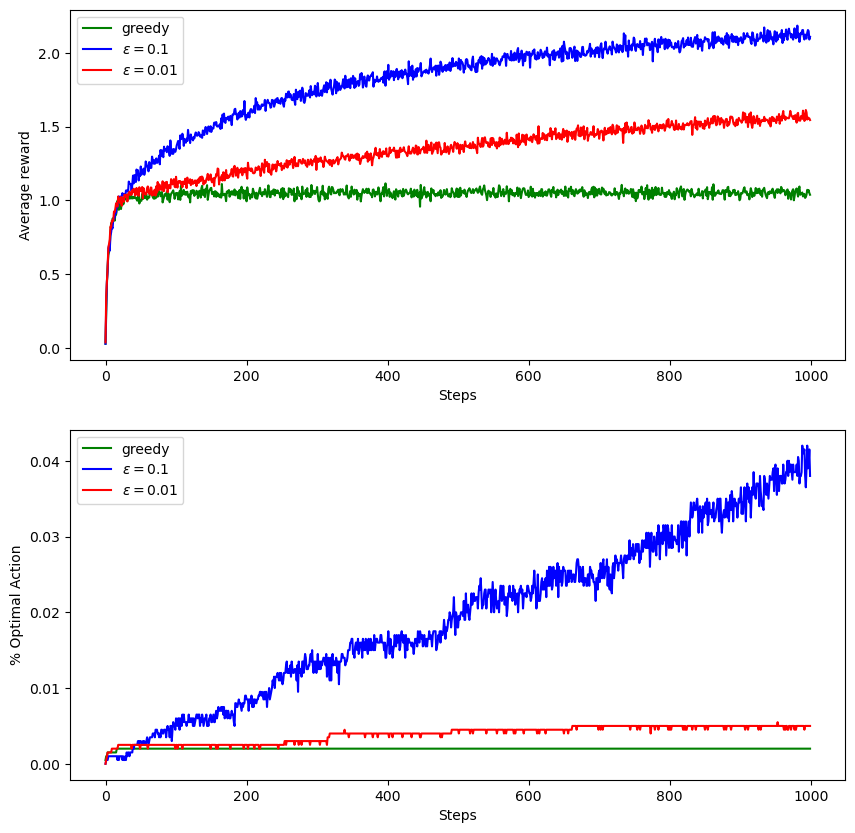

In [10]:
runs = 2000
k = 2000
Bandit.run_and_plot_experiments(
    steps=1000,
    exp_bandit_agent_dict={
        "greedy": (
            StationaryMultiArmedBandit(k=k, runs=runs),
            Agent(k=k, runs=runs, epsilon=0)
        ),
        r"$\epsilon=0.1$": (
            StationaryMultiArmedBandit(k=k, runs=runs),
            Agent(k=k, runs=runs, epsilon=0.1)
        ),
        r"$\epsilon=0.01$": (
            StationaryMultiArmedBandit(k=k, runs=runs),
            Agent(k=k, runs=runs, epsilon=0.01)
        ),
    },
)

# Change k=2000 with just $\epsilon=0$ and $\epsilon=0.01$

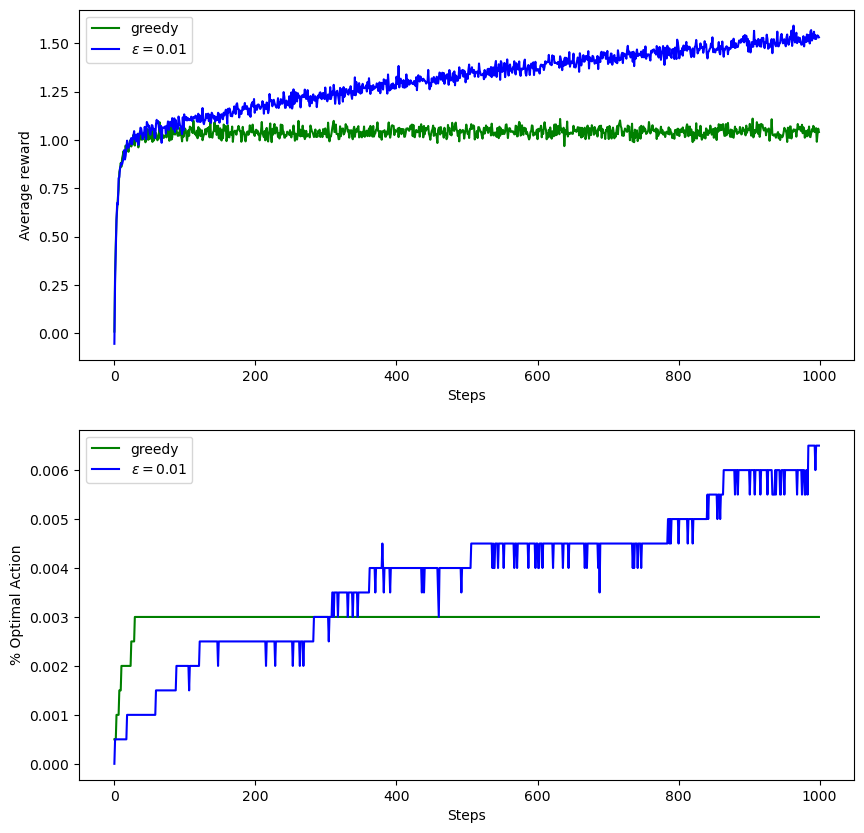

In [11]:
runs = 2000
k = 2000
Bandit.run_and_plot_experiments(
    steps=1000,
    exp_bandit_agent_dict={
        "greedy": (
            StationaryMultiArmedBandit(k=k, runs=runs),
            Agent(k=k, runs=runs, epsilon=0)
        ),
        # "epsilon=0.1": (
        #     StationaryMultiArmedBandit(k=k, runs=runs),
        #     Agent(k=k, runs=runs, epsilon=0.1)
        # ),
        r"$\epsilon=0.01$": (
            StationaryMultiArmedBandit(k=k, runs=runs),
            Agent(k=k, runs=runs, epsilon=0.01)
        ),
    },
)

DOWNFALLS OF GREEDY SINCE IT IS ONLY EXPLOITING ONE ACTION RATHER THAN EXPERIMENTING AND EXPLORING OTHER ACTIONS

### k = 10, $\epsilon=0, 0.01, 0.9$

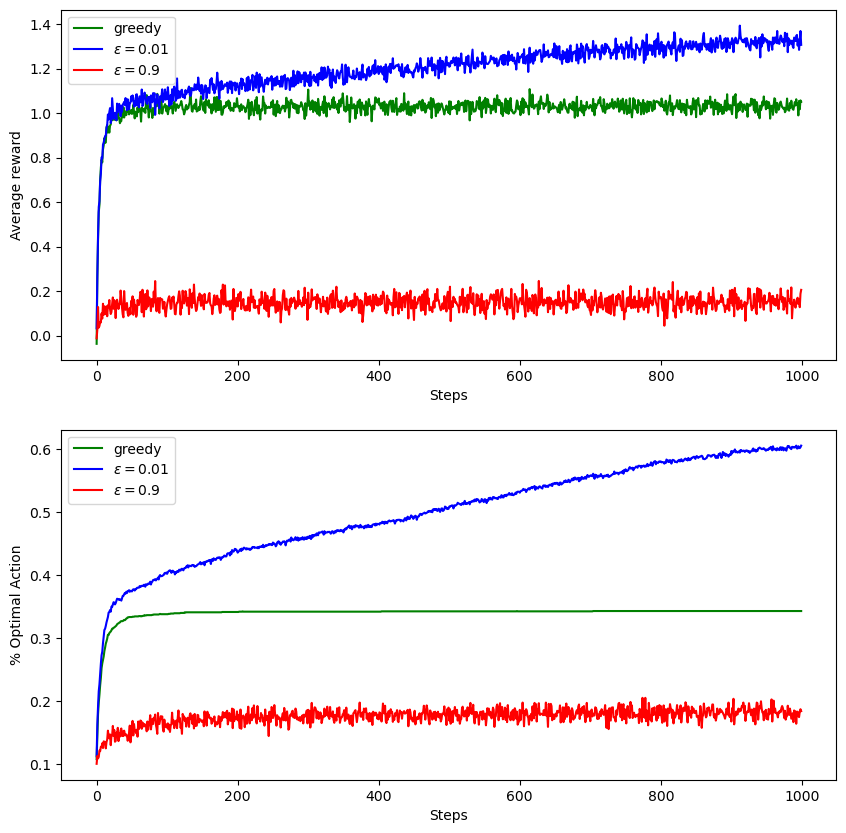

In [12]:
runs = 2000
k = 10
Bandit.run_and_plot_experiments(
    steps=1000,
    exp_bandit_agent_dict={
        "greedy": (
            StationaryMultiArmedBandit(k=k, runs=runs),
            Agent(k=k, runs=runs, epsilon=0)
        ),
        r"$\epsilon=0.01$": (
            StationaryMultiArmedBandit(k=k, runs=runs),
            Agent(k=k, runs=runs, epsilon=0.01)
        ),
         r"$\epsilon=0.9$": (
            StationaryMultiArmedBandit(k=k, runs=runs),
            Agent(k=k, runs=runs, epsilon=0.9)
        ),
    },
)